In [1]:
from robust_hw import columns, extract_rotations, interpolate, integrate, read_hdf, read_csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
from scipy.ndimage import uniform_filter, gaussian_filter

In [2]:
period = 10
log_path = 'data/Z-230901A.csv'

theta_raw = np.unwrap(read_csv(log_path, columns['theta']))

freq_raw = -1.0 * read_csv(log_path, 'Sensor1 [Fundamental freq]')
theta_ext, freq_ext = extract_rotations(theta_raw, freq_raw)
freq_sgn = integrate(freq_ext, np.zeros(freq_ext.size), period)
freq_bgd = interpolate(freq_ext, period, period - 2)
freq_int = integrate(freq_ext, freq_bgd, period)

In [3]:
s1_factor = read_csv(log_path, columns['s1_factor'])
s1_background = read_csv(log_path, columns['s1_bgd'])
s1_signal = read_csv(log_path, columns['s1_sgn'])
# s1_cleaned_signal = read_csv(log_path, 'Mag3 [QCM,S1 cleaned signal] (um/rot)')
factor = 1e-3

theta_ext, signal = extract_rotations(theta_raw, s1_signal)
theta_ext, background = extract_rotations(theta_raw, s1_background)

# _, log_signal = extract_rotations(theta_raw, read_csv(log_path, 'Mag3 [Holt Winters feedback,S1 Smooth signal] (layers)'))

In [40]:
s1_factor = read_csv(log_path, columns['s2_factor'])
s1_background = read_csv(log_path, columns['s2_bgd'])
s1_signal = read_csv(log_path, columns['s2_sgn'])
s1_cleaned_signal = read_csv(log_path, 'Mag3 [QCM,S2 cleaned signal] (um/rot)')
factor = 1e-3

theta_ext, signal = extract_rotations(theta_raw, s1_signal)
theta_ext, background = extract_rotations(theta_raw, s1_background)

_, log_signal = extract_rotations(theta_raw, read_csv(log_path, 'Mag3 [Holt Winters feedback,S2 Smooth signal] (layers)'))

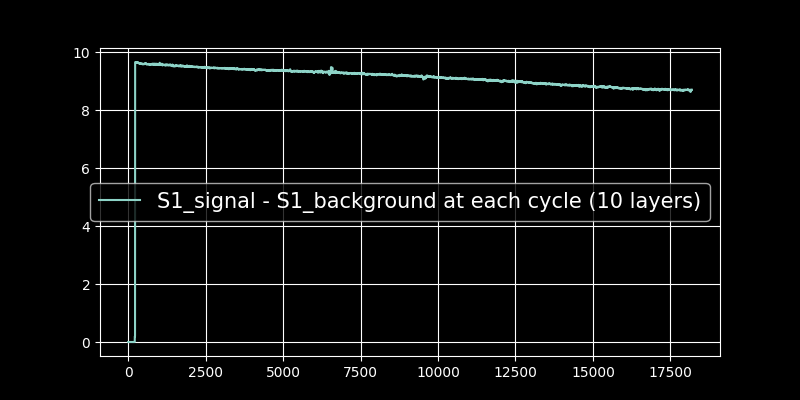

In [5]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(theta_raw, freq_raw)
# ax.plot(theta_ext, freq_ext)
ax.plot(theta_raw / (2 * np.pi), factor * (s1_signal - s1_background), label="S1_signal - S1_background at each cycle (10 layers)")
# ax.plot(theta_ext[::period], factor * (signal - background)[::period], label="S1_signal - S1_background at each cycle (10 layers)")
# ax.plot(theta_raw / (2 * np.pi), s1_cleaned_signal, linestyle='dashed', label="S1_cleaned_signal from output.csv")
# ax.plot(theta_ext[::period], series, label="S1 smoothing input from debug.log")
# ax.plot(theta_ext[::period][5:], input[:26, 1])

ax.legend(fontsize=15)
ax.grid(True)
# ax.set_ylim(0.85, 1.05)
plt.show()

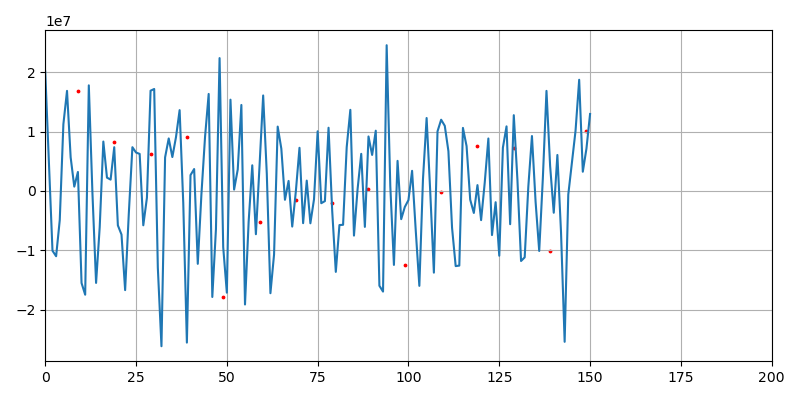

In [14]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(theta_ext, np.gradient(freq_ext))
ax.scatter(theta_ext[period - 1::period], np.gradient(freq_ext)[period - 4::period], s=3, c='r')
ax.grid(True)

ax.set_xlim(0, 200)
fig.tight_layout()
plt.show()

# Robust smoothing

In [6]:
from robust_hw import create_smoother, initialise, smoothing_step
import jax.numpy as jnp
from tqdm.auto import tqdm
from tqdm import trange

In [6]:
theta_raw = np.unwrap(read_csv(log_path, columns['theta']))
theta_ext, freq_ext = extract_rotations(theta_raw, freq_raw)

In [219]:
# series of signal - background
theta = theta_ext[::period]
# series = freq_int[::period]
series = (signal - background)[::period]

# series /= series.max()

# results of a training
smoothe_over_signal, smoothe_over_gradient, smoothe_over_variance = 5, 155, 22

#creating a smoother object
smoother = create_smoother(smoothe_over_signal, smoothe_over_gradient, smoothe_over_variance)

# skipping first n_start points and allocating n_warmup points to create an initial state
n_start, n_warmup = 200, 2 * max(smoothe_over_signal, smoothe_over_gradient, smoothe_over_variance)

warmup, samples = (jnp.array(series[n_start:n_start + n_warmup]),
                   jnp.array(series[n_start + n_warmup:]))

step = smoothing_step(smoother)

# creating an initial state
state = initialise(smoother, warmup)

# performing real-time smoothing
result = []
states = []
for elem in tqdm(samples):
    smoothed, state = step(elem, state)
    result.append(smoothed)
    states.append(state)

  0%|          | 0/1310 [00:00<?, ?it/s]

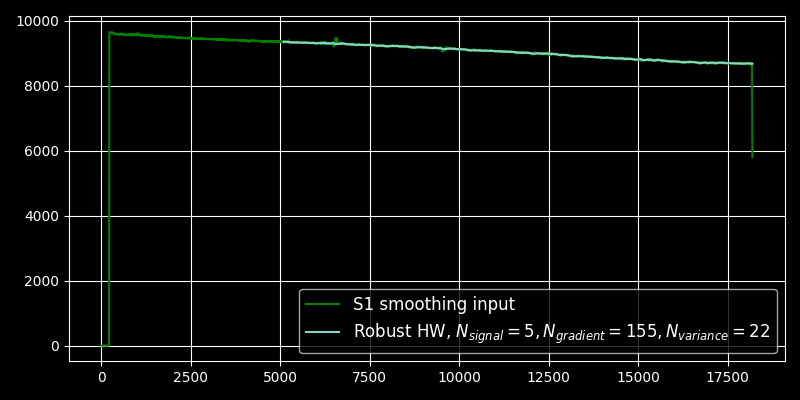

In [220]:
import matplotlib.pyplot as plt

%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(theta_raw / (2 * np.pi), old_s1_ftr, c='b', alpha=0.7, linestyle='dashed', label="s1 factor")
# ax.plot(theta_ext[::period], log_signal[::period], c='r', alpha=0.7, linestyle='dashed', label="Martin's Robust HW")
# ax.plot(theta[n_start + n_warmup:], [state.moment for state in states])
# ax.scatter(theta, series, s=1, alpha=0.1, c='k', label=r'$s1_{signal} - s1_{bgd}$')
ax.plot(theta, series, c='g', label="S1 smoothing input")
ax.plot(theta[n_start + n_warmup:], result, alpha=1.0,
        label=fr'Robust HW, $N_{{signal}} = {smoothe_over_signal}, '\
              fr'N_{{gradient}} = {smoothe_over_gradient}, '\
              fr'N_{{variance}} = {smoothe_over_variance}$')
# ax.plot(theta_ext[::period], log_signal[::period], c='r', alpha=0.7, linestyle='dashed', label="Martin's Robust HW")

ax.legend(fontsize=12)
# ax.set_ylim(0.86, 1.0)
ax.grid(True)
fig.tight_layout()
plt.show()

In [7]:
from robust_hw import inject_hyperparams, meta_step, robust_holt_winters
import optax as ox
import jax
import jax.numpy as jnp

log_path, period = 'data/Z-230901A.csv', 10

theta_raw = jnp.unwrap(read_csv(log_path, columns['theta']))
signal = read_csv(log_path, columns["s1_sgn"])
background = read_csv(log_path, columns["s1_bgd"])

print("Preparing data...")

_, signal = extract_rotations(theta_raw, signal)
_, background = extract_rotations(theta_raw, background)

series = (signal - background)[::period]


Preparing data...


In [8]:
init_value, n_iter, learning_rate = 2.0, 10000, 5e-3

smoother = inject_hyperparams(robust_holt_winters)(lambda1=init_value**-1,
                                                   lambda2=init_value**-1,
                                                   lambda_sigma=init_value**-1)
schedule = ox.cosine_onecycle_schedule(n_iter, learning_rate)
opt = ox.inject_hyperparams(ox.adam)(learning_rate=schedule)

In [10]:
n_start, n_warmup, lookahead = 200, 200, 10

train, warmup = series[n_start + n_warmup:], series[n_start:n_start + n_warmup]

In [11]:
decay = jnp.full(3, -jnp.log(init_value - 1))
opt_state = opt.init(decay)

n_start, n_warmup = 200, 200

step = meta_step(smoother, opt, lookahead)
train, warmup = series[n_start + n_warmup:], series[n_start:n_start + n_warmup]
init_state = smoother.init(warmup)
criteria, decays = [], []

with trange(n_iter, desc="Training") as pbar:
    for i in pbar:
        if i % 500 == 0:
            new_values = jax.nn.sigmoid(decay)**-1
            pbar.write(f"sum_over_signal = {new_values[0]:<7.3f}, " +
                       f"sum_over_gradient = {new_values[1]:<7.3f}, " +
                       f"sum_over_variance = {new_values[2]:<7.3f}")


        crit, decay, opt_state = step(decay, train, init_state, opt_state)
        pbar.set_postfix_str(f"loss = {crit:.2e}")

        criteria.append(crit)
        decays.append(decay)

Training:   0%|                                                                                 | 0/10000 [00:00<?, ?it/s]

sum_over_signal = 2.000  , sum_over_gradient = 2.000  , sum_over_variance = 2.000  


Training:   7%|███▌                                                 | 672/10000 [00:02<00:14, 631.85it/s, loss = 2.51e+05]

sum_over_signal = 2.156  , sum_over_gradient = 2.159  , sum_over_variance = 1.942  


Training:  11%|█████▊                                              | 1128/10000 [00:03<00:09, 937.56it/s, loss = 2.11e+05]

sum_over_signal = 2.654  , sum_over_gradient = 2.710  , sum_over_variance = 2.765  


Training:  17%|████████▋                                          | 1702/10000 [00:03<00:07, 1040.27it/s, loss = 1.72e+05]

sum_over_signal = 3.634  , sum_over_gradient = 4.493  , sum_over_variance = 6.613  


Training:  21%|██████████▉                                        | 2149/10000 [00:03<00:07, 1073.98it/s, loss = 1.41e+05]

sum_over_signal = 6.011  , sum_over_gradient = 10.023 , sum_over_variance = 12.856 


Training:  27%|█████████████▊                                     | 2697/10000 [00:04<00:06, 1084.58it/s, loss = 1.34e+05]

sum_over_signal = 12.158 , sum_over_gradient = 17.981 , sum_over_variance = 19.615 


Training:  32%|████████████████▏                                  | 3170/10000 [00:04<00:05, 1154.23it/s, loss = 1.31e+05]

sum_over_signal = 17.395 , sum_over_gradient = 27.860 , sum_over_variance = 26.170 


Training:  36%|██████████████████▌                                | 3638/10000 [00:05<00:05, 1131.53it/s, loss = 1.29e+05]

sum_over_signal = 23.697 , sum_over_gradient = 41.641 , sum_over_variance = 27.468 


Training:  42%|█████████████████████▍                             | 4208/10000 [00:05<00:05, 1123.58it/s, loss = 1.29e+05]

sum_over_signal = 26.938 , sum_over_gradient = 54.041 , sum_over_variance = 26.692 


Training:  47%|███████████████████████▉                           | 4682/10000 [00:06<00:04, 1160.42it/s, loss = 1.29e+05]

sum_over_signal = 25.973 , sum_over_gradient = 64.112 , sum_over_variance = 26.340 


Training:  52%|██████████████████████████▎                        | 5152/10000 [00:06<00:04, 1154.72it/s, loss = 1.29e+05]

sum_over_signal = 24.261 , sum_over_gradient = 72.900 , sum_over_variance = 26.138 


Training:  56%|████████████████████████████▋                      | 5627/10000 [00:07<00:03, 1160.13it/s, loss = 1.29e+05]

sum_over_signal = 22.965 , sum_over_gradient = 80.462 , sum_over_variance = 26.003 


Training:  62%|███████████████████████████████▋                   | 6209/10000 [00:07<00:03, 1102.56it/s, loss = 1.29e+05]

sum_over_signal = 21.974 , sum_over_gradient = 86.560 , sum_over_variance = 26.077 


Training:  66%|█████████████████████████████████▊                 | 6640/10000 [00:07<00:03, 1034.86it/s, loss = 1.29e+05]

sum_over_signal = 21.338 , sum_over_gradient = 91.254 , sum_over_variance = 25.932 


Training:  72%|████████████████████████████████████▍              | 7155/10000 [00:08<00:02, 1003.97it/s, loss = 1.29e+05]

sum_over_signal = 20.919 , sum_over_gradient = 94.662 , sum_over_variance = 25.961 


Training:  77%|███████████████████████████████████████            | 7670/10000 [00:08<00:02, 1020.67it/s, loss = 1.29e+05]

sum_over_signal = 20.651 , sum_over_gradient = 97.022 , sum_over_variance = 25.916 


Training:  82%|█████████████████████████████████████████▊         | 8197/10000 [00:09<00:01, 1054.18it/s, loss = 1.29e+05]

sum_over_signal = 20.465 , sum_over_gradient = 98.649 , sum_over_variance = 25.814 


Training:  87%|████████████████████████████████████████████▎      | 8684/10000 [00:09<00:01, 1173.89it/s, loss = 1.29e+05]

sum_over_signal = 20.355 , sum_over_gradient = 99.687 , sum_over_variance = 25.790 


Training:  91%|██████████████████████████████████████████████▋    | 9144/10000 [00:10<00:00, 1062.37it/s, loss = 1.29e+05]

sum_over_signal = 20.299 , sum_over_gradient = 100.260, sum_over_variance = 25.778 


Training:  97%|█████████████████████████████████████████████████▎ | 9675/10000 [00:10<00:00, 1044.37it/s, loss = 1.29e+05]

sum_over_signal = 20.275 , sum_over_gradient = 100.501, sum_over_variance = 25.772 


Training: 100%|███████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 902.67it/s, loss = 1.29e+05]


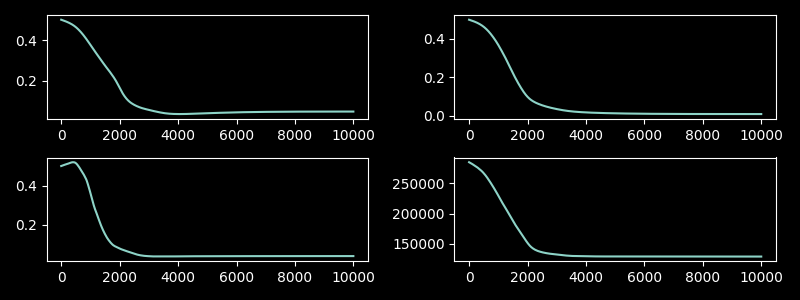

In [12]:
%matplotlib widget
fig, ax = plt.subplots(2, 2, figsize=(8, 3))
ax[0][0].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 0]))
ax[0][1].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 1]))
ax[1][0].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 2]))
ax[1][1].plot(criteria)
fig.tight_layout()
plt.show()